# Classsifying handwritten Japanese characters (hiragana) using a neural net

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import glob
from skimage import io
import re
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import math
import matplotlib
from skimage.transform import rescale
from skimage.filters import threshold_otsu

# This is needed for matplotlib to display Japanese characters
# see https://openbook4.me/sections/1674
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'

## Load and inspect data

In [2]:
files = glob.glob('data/hiragana73/*/*.png')
m = len(files) # nuber of examples
print('Loaded %d examples of handwritten hiragana characters.' %m)

Loaded 80000 examples of handwritten hiragana characters.


In [3]:
# Check if all the data is the same shape
img_shapes = Counter()
for file in files:
    img_shape = io.imread(file).shape
    img_shapes[img_shape] += 1
    
img_shapes

Counter({(48, 48): 61075, (48, 48, 3): 18916, (48, 48, 4): 9})

Images are 48x48 pixels. (48x48) files are greyscale, (48x48x3) files are RGB colour; we have a considerable number of both. Let's see what they look like.

In [4]:
# Load one greyscale and one colour example
file_grey = next(file for file in files if io.imread(file).shape==(48, 48))
file_rgb = next(file for file in files if io.imread(file).shape==(48, 48, 3))

In [5]:
image_grey = io.imread(file_grey)
image_rgb = io.imread(file_rgb)

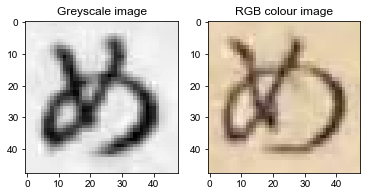

In [6]:
plt.subplot(1, 2, 1)
plt.imshow(image_grey, cmap='gray')
plt.title('Greyscale image')

plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
plt.title('RGB colour image')

plt.show()

Two hiragana "め" characters.

## Clean and engineer data

### Remove colour

Colour is not useful information for us, and it makes our data have different shapes, so we'll to convert our RGB colour images to greyscale.

In [7]:
# Convert colour to greyscale
image_rgb = io.imread(file_rgb, as_gray=True)
image_rgb.shape

(48, 48)

Our converted colour file now has the same shape as our greyscale image.

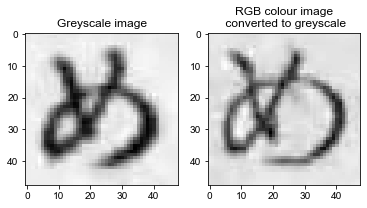

In [8]:
# Check colour-to-greyscale conversion looks okay.

plt.subplot(1, 2, 1)
plt.imshow(image_grey, cmap='gray')
plt.title('Greyscale image')

plt.subplot(1, 2, 2)
plt.imshow(image_rgb, cmap='gray')
plt.title('RGB colour image\n converted to greyscale')

plt.show()

Let's take a look at a random sample of our data to see if we can do anthing else.

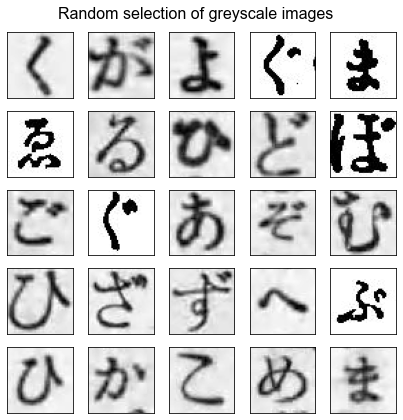

In [9]:
n = 25
fig_side = int(math.sqrt(n))
rand_indices = np.random.choice(m, size=n, replace=False)

# Remove ticks to make things look cleaner
axis_params_dict = {
    'axis':'both',       
    'which':'both',      # major and minor ticks
    'bottom':False,      # bottom ticks off
    'left':False,        # left ticks off
    'labelbottom':False, # bottom labels off
    'labelleft':False}   # left labels off

plt.figure(figsize=(7, 7))
for i in range(n):
    plt.subplot(fig_side, fig_side, i+1)
    image = io.imread(files[rand_indices[i]], as_gray=True)
    plt.imshow(image, cmap='gray')
    plt.tick_params(**axis_params_dict)
plt.suptitle('Random selection of greyscale images', fontsize=16, y=0.93)
plt.show()

Two things:

* The images are 48x48, which is ~2,300 pixels. That's going to mean a big input layer and a big hidden layer in the neural net, which means a lot of CPU time. Also, the high resolution means the NN might overfit on small, meaningless details which will lead to worse test performance. So we'll reduce the images by 0.5 on each side (i.e. to 24x24), which will reduce the amount of data we have to process by 75% and force the NN to learn bigger, more meaingful features.

* Greyscale is better than colour, but all the different shades of grey will make it difficult for the neural network to achieve high accuracy - the same character might be written in different shades of grey in different images, and on a background which is also a different shade of grey. To fix this, we want binary black-and-white images, which we'll achieve using thresholding.

### Reduce image size

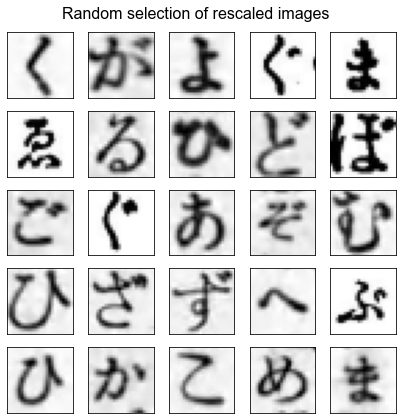

In [10]:
plt.figure(figsize=(7, 7))
for i in range(n):
    plt.subplot(fig_side, fig_side, i+1)
    image = io.imread(files[rand_indices[i]], as_gray=True)
    
    # Rescale
    image = rescale(image, scale=0.5)
    
    plt.imshow(image, cmap='gray')
    plt.tick_params(**axis_params_dict)
plt.suptitle('Random selection of rescaled images', fontsize=16, y=0.93)
plt.show()

Looks acceptable.

### Binarise (make images black-and-white)

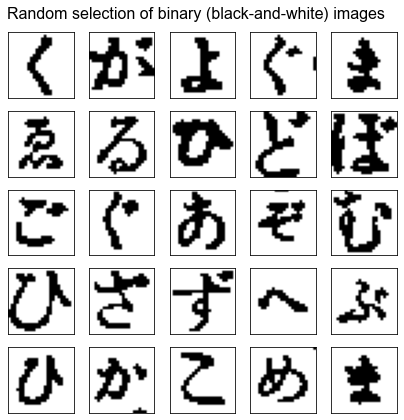

In [11]:
plt.figure(figsize=(7, 7))
for i in range(n):
    plt.subplot(fig_side, fig_side, i+1)
    image = io.imread(files[rand_indices[i]], as_gray=True)
    
    # Rescale
    image = rescale(image, scale=0.5)
    
    # Binarise
    thresh = threshold_otsu(image)
    image = image > thresh
    
    plt.imshow(image, cmap='gray')
    plt.tick_params(**axis_params_dict)
plt.suptitle('Random selection of binary (black-and-white) images', fontsize=16, y=0.93)
plt.show()

### Engineer target array

The data comes labelled, but the labels are encoded in the directory names in the form of unicode codes. E.g. if we take the file `data/hiragana73/U304A/1900_780422_0014.png` the directory name `U304A` is the unicode code for "お":

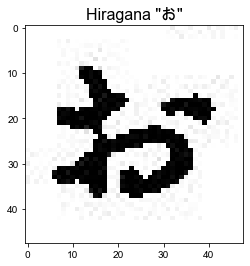

In [12]:
image = io.imread('data/hiragana73/U304A/1900_780422_0014.png')
plt.imshow(image, cmap='gray')
plt.title(u'Hiragana "\u304a"', fontsize=16)
plt.show()

This is what our list of files looks like:

In [13]:
files[:5]

['data/hiragana73/U3081/1942_1877910_0247.png',
 'data/hiragana73/U3081/1941_1133168_0068.png',
 'data/hiragana73/U3081/1935_1264256_0398.png',
 'data/hiragana73/U3081/1929_1453088_0040.png',
 'data/hiragana73/U3081/1900_754949_0023.png']

The [hiragana unicode block](https://en.wikipedia.org/wiki/Hiragana_(Unicode_block%29) covers U+30[4-9]X, where X = [0-9]|[A-F]. Time to break out some regular expressions.

In [14]:
# We need to preserve the full filepaths for loading the images
char_codes = files.copy()

idx = 0
for char_code in char_codes:
    code = re.search(r'[0-9]{3}[0-9A-F]', char_code)
    if code:
        char_codes[idx] = code.group(0)
    else:
        print('Invalid characer code:', char_code)
    idx += 1

In [15]:
char_codes[:5]

['3081', '3081', '3081', '3081', '3081']

Now let's make it human-readable.

In [16]:
for i in range(len(char_codes)):
    char_codes[i] = chr(int(char_codes[i], 16))
    
char_codes[:5]

['め', 'め', 'め', 'め', 'め']

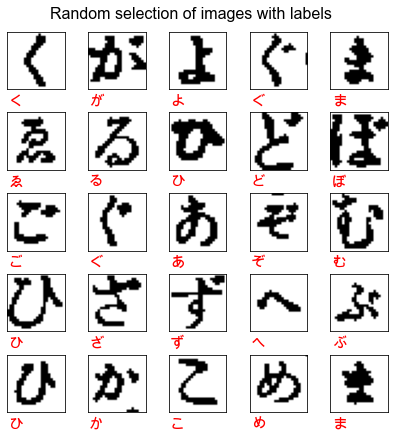

In [17]:
# Let's show a few exmaples as a check that the labels are correct
plt.figure(figsize=(7, 7))
for i in range(n):
    
    plt.subplot(fig_side, fig_side, i+1)
    image = io.imread(files[rand_indices[i]], as_gray=True)
    
    # Rescale
    image = rescale(image, scale=0.5)    
    
    # Binarise
    thresh = threshold_otsu(image)
    image = image > thresh    
    plt.imshow(image, cmap='gray')
    
    # Label
    plt.text(0, 30, char_codes[rand_indices[i]], color='r', fontsize=15)
    
    plt.tick_params(**axis_params_dict)
plt.subplots_adjust(hspace=0.4)
plt.suptitle('Random selection of images with labels', fontsize=16, y=0.93)
plt.show()

Looks good! Let's continue.

In [18]:
# Check numbers of each character
chars_dict = Counter(char_codes)
# Now sort according to frequency (https://stackoverflow.com/a/613218) and display
chars_dict_sorted = sorted(chars_dict.items(), key=lambda kv: kv[1])

In [19]:
print('Least common characters:', chars_dict_sorted[:5])
print('Most common characters:', chars_dict_sorted[-5:])

Least common characters: [('ぷ', 112), ('ぴ', 126), ('ぽ', 261), ('ぱ', 262), ('ぺ', 268)]
Most common characters: [('た', 1285), ('ん', 1285), ('し', 1285), ('や', 1285), ('そ', 1285)]


We can see that in some cases we have ~1,200 examples of a character, but in other cases we only have ~100 examples. So we should be careful to stratify when taking a sample of our data.

### Create train and test datasets

In [20]:
# Feature array
X = np.array([io.imread(file, as_gray=True) for file in files])
X.shape

(80000, 48, 48)

In [21]:
# Before rescaling and binarisation
print(X[0])
print('')
print(np.mean(X[0]))
print('')
print(X.shape)

[[0.84009961 0.84737725 0.85129882 ... 0.83619373 0.83619373 0.83060549]
 [0.84009961 0.84737725 0.85129882 ... 0.83619373 0.83170667 0.83284549]
 [0.83617804 0.84345569 0.85129882 ... 0.83284549 0.82892392 0.82835843]
 ...
 [0.81907098 0.81179333 0.80563176 ... 0.83785255 0.8375698  0.8375698 ]
 [0.82355804 0.8134749  0.80955333 ... 0.84177412 0.84933451 0.85325608]
 [0.82131804 0.81739647 0.81404039 ... 0.85353882 0.86138196 0.86109922]]

0.7230765939882898

(80000, 48, 48)


In [22]:
## Rescale and binarise

# Need a different shape array for the rescaled images
rescale_factor = 0.5
image_side_new = int(X.shape[1] * rescale_factor)
X_new = np.zeros(shape=(m, image_side_new, image_side_new))

for i in range(X.shape[0]):
    image = X[i]
    image = rescale(image, rescale_factor)
    thresh = threshold_otsu(image)
    image = image > thresh
    X_new[i] = image
    
X = X_new

In [23]:
# Check it worked
print(X[0])
print('')
print(np.mean(X[0]))
print('')
print(X.shape)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 0.

In [24]:
# Target array
y = np.asarray(char_codes)
y.shape

(80000,)

I'm running this on a laptop CPU, so 80,000 examples is too many. Let's make the dataset smaller. As far as I can tell, the easiest way to do a stratified sample is to use `sklearn.model_selection.train_test_split()` using the `stratify` option. So I'll use that, but I'm *not* actually creating my train and test sets here, I'm just using it to create a stratified sample!

In [25]:
# Preserve the indices for later
idx = np.arange(m)

# Keep a small fraction of the dataset ("keep") and throw the rest away ("junk")
X_junk, X_keep, y_junk, y_keep, idx_junk, idx_keep = train_test_split(X, y, idx, test_size=0.1, stratify=y)

In [26]:
X = X_keep
X.shape

(8000, 24, 24)

In [27]:
y = y_keep
y.shape

(8000,)

In [28]:
idx = idx_keep
idx.shape

(8000,)

In [29]:
# sklearn needs a flat feature array
m = X.shape[0] # number of examples
X = X.reshape(m, -1)
X.shape

(8000, 576)

## Train and test the neural net

In [30]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, test_size=0.1, stratify=y)

I'm going to go with [this](https://stats.stackexchange.com/a/1097) recommendation and go for one hidden layer, number of nodes in hidden layer is between the number of nodes in input and output layers. Specifically, I'm going to use the geometric mean of the input and output layer sizes.

In [31]:
input_layer_size = X.shape[1]
output_layer_size = len(set(y))
hidden_layer_size = int(math.sqrt(input_layer_size*output_layer_size))

clf = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,))
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(205,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

## Final result

In [32]:
X_pred = clf.predict(X_test)
accuracy = np.mean(X_pred == y_test)
print('Accuracy: %.1f%%' %(accuracy*100))

Accuracy: 96.1%


## Commentary

Let's display some correctly-predicted examples, just for fun.

In [33]:
## Get correctly-predicted examples

# Get indices where X_pred == y_test
X_correct_idx = np.where(X_pred == y_test)

# Output is a tuple which contains an array,
# i.e. our array of indices is the 0th element of the tuple
X_correct_idx = X_correct_idx[0]

# Get corresponding indices from original 80,000 sample
idx_correct = idx_test[X_correct_idx]
idx_correct.shape

(769,)

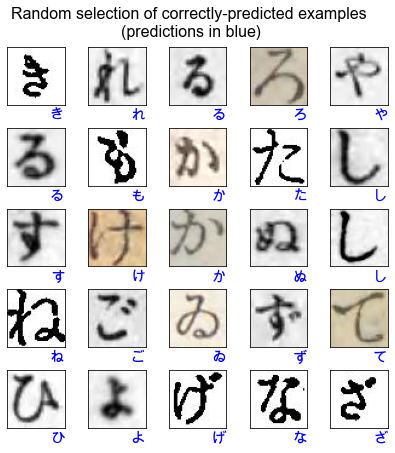

In [34]:
# Select some random indices from correctly-predicted examples to display
rand_indices = np.random.choice(idx_correct.shape[0], size=n, replace=False)

# Display
plt.figure(figsize=(7, 7))
for i in range(n):
    plt.subplot(fig_side, fig_side, i+1)
    image = io.imread(files[idx_correct[rand_indices[i]]])

    if len(image.shape)==3:
        plt.imshow(image)
    if len(image.shape)==2:
        plt.imshow(image, cmap='gray')
        
    plt.text(35, 60, X_pred[X_correct_idx[rand_indices[i]]], color='b', fontsize=15)
        
    plt.tick_params(**axis_params_dict)
    
plt.suptitle('Random selection of correctly-predicted examples \n(predictions in blue)',
             fontsize=16, y=0.96)
plt.subplots_adjust(hspace=0.4)
plt.show()

And now let's look at examples where the prediction was wrong.

In [35]:
## Get incorrectly-predicted examples
X_incorrect_idx = np.where(X_pred != y_test)
X_incorrect_idx = X_incorrect_idx[0]
idx_incorrect = idx_test[X_incorrect_idx]
idx_incorrect.shape

(31,)

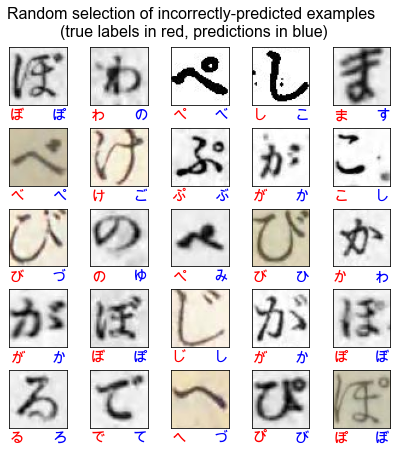

In [36]:
# Select some random indices from correctly-predicted examples to display
rand_indices = np.random.choice(idx_incorrect.shape[0], size=n, replace=False)

# Display
plt.figure(figsize=(7, 7))
for i in range(n):
    plt.subplot(fig_side, fig_side, i+1)
    image = io.imread(files[idx_incorrect[rand_indices[i]]])

    if len(image.shape)==3:
        plt.imshow(image)
    if len(image.shape)==2:
        plt.imshow(image, cmap='gray')
        
    plt.text(0, 60, char_codes[idx_incorrect[rand_indices[i]]], color='r', fontsize=15)
    plt.text(35, 60, X_pred[X_incorrect_idx[rand_indices[i]]], color='b', fontsize=15)
        
    plt.tick_params(**axis_params_dict)
    
plt.suptitle('Random selection of incorrectly-predicted examples \n(true labels in red, predictions in blue)',
             fontsize=16, y=0.96)
plt.subplots_adjust(hspace=0.4)
plt.show()